In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from utils import *
from model.data_loader import *
from model.data_loader_old import *
from model.unet_baseline import unet
from model.unet_ternaus import ternausNet16
from model.unet_ternaus_tweaked import ternausNet16_tweaked
from model.unet_pix2pix_paper import unet_pix2pix_paper
from model.unet_pix2pix_pytorch import unet_pix2pix_pytorch

In [3]:
train_pth = 'data/membrane/train'
test_pth = 'data/membrane/test'
results_pth = 'results/'
pretrained_pth = 'pretrained/'

# Data augmentation

In [4]:
input_generator_train = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    rescale=1./255,           #  rescale pixel vals 0-255 --> 0.0-1.0
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect', #nearest
    data_format='channels_last',
    validation_split=0.0
)
target_generator_train = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # No brightness transform on target mask
    rescale=1./255,           #  rescale pixel vals 0-255 --> 0.0-1.0
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

input_generator_test = ImageDataGenerator(
    rescale=1./255,           #  rescale pixel vals 0-255 --> 0.0-1.0
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

target_generator_test = ImageDataGenerator(
    rescale=1./255,           #  rescale pixel vals 0-255 --> 0.0-1.0
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

# Models under test 

# Baseline

In [5]:
img_sz = (512, 512, 1)
batch_sz = 2

# Models
models = [
    ['unet_baseline', unet, dict(input_size=img_sz, transpose=True)]
]

# Data loaders
train_loader = loader(train_pth, input_generator_train, target_generator_train, batch_sz=batch_sz, img_sz=img_sz[:2])
test_loader = loader(test_pth, input_generator_test, target_generator_test, batch_sz=batch_sz, img_sz=img_sz[:2])

In [ ]:
test_title = 'baseline_512px_500steps_10epochs'

training_params = dict(
    train_steps=500, 
    val_steps=100, 
    epochs=10, 
    iterations=1, 
    lr=1e-4
)

for model in models:
    print(f'\nTESTING MODEL: {model[0]}')
    save_pth = f'{pretrained_pth}{model[0]}_{test_title}.h5'
    results = test_model(model[1], train_loader, test_loader, **training_params, 
                         model_params=model[2], save_pth=save_pth)
    results_df = hists2df(results)
    results_df.to_csv(f'{results_pth}{model[0]}_{test_title}.csv')

# Full Test: 5 epochs of 2000 training steps

In [5]:
img_sz = (256, 256, 1)
batch_sz = 2

# Models
models = [
    ['unet_baseline',           unet,                 dict(input_size=img_sz, transpose=True)],
    ['unet_baseline_upsampled', unet,                 dict(input_size=img_sz, transpose=False)],
    ['unet_pix2pix_paper',      unet_pix2pix_paper,   dict(input_size=img_sz)],
    ['unet_pix2pix_pytorch',    unet_pix2pix_pytorch, dict(input_size=img_sz)],
    ['unet_ternaus_nopre',      ternausNet16_tweaked, dict(input_size=img_sz, dropout=False, batch_norm=False, pretrained=False)],
    ['unet_ternaus',            ternausNet16,         dict(input_size=img_sz)],
    ['unet_ternaus_drop',       ternausNet16_tweaked, dict(input_size=img_sz, dropout=True,  batch_norm=False, pretrained=True)],
    ['unet_ternaus_bn',         ternausNet16_tweaked, dict(input_size=img_sz, dropout=False, batch_norm=True,  pretrained=True)],
    ['unet_ternaus_dropbn',     ternausNet16_tweaked, dict(input_size=img_sz, dropout=True,  batch_norm=True,  pretrained=True)]
]

# Data loaders
train_loader = loader(train_pth, input_generator_train, target_generator_train, batch_sz=batch_sz, img_sz=img_sz[:2])
test_loader = loader(test_pth, input_generator_test, target_generator_test, batch_sz=batch_sz, img_sz=img_sz[:2])

In [6]:
test_title = '5epochs'

training_params = dict(
    train_steps=500, 
    val_steps=100, 
    epochs=5, 
    iterations=3, 
    lr=1e-4
)

for model in models:
    print(f'\nTESTING MODEL: {model[0]}')
    save_pth = f'{pretrained_pth}{model[0]}.h5'
    results = test_model(model[1], train_loader, test_loader, **training_params, 
                         model_params=model[2], save_pth=save_pth)
    results_df = hists2df(results)
    results_df.to_csv(f'{results_pth}{model[0]}_{test_title}.csv')


TESTING MODEL: unet_baseline
Epoch 1/5
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
1999/2000 [============================>.] - ETA: 0s - loss: 1.1967 - acc: 0.9010Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
2000/2000 [==============================] - 992s 496ms/step - loss: 1.1966 - acc: 0.9010 - val_loss: 1.0991 - val_acc: 0.9367
Epoch 2/5
2000/2000 [==============================] - 985s 493ms/step - loss: 1.0032 - acc: 0.9439 - val_loss: 1.0317 - val_acc: 0.9312
Epoch 3/5
  48/2000 [..............................] - ETA: 15:29 - loss: 0.9253 - acc: 0.9513

KeyboardInterrupt: 

TESTING MODEL: unet_baseline 
train_steps=1000
epochs=5

new augmentation

loss: 0.4721 - acc: 0.8949 - val_loss: 0.3291 - val_acc: 0.9325
loss: 0.3288 - acc: 0.9284 - val_loss: 0.3316 - val_acc: 0.9346
loss: 0.2828 - acc: 0.9381 - val_loss: 0.3206 - val_acc: 0.9349
loss: 0.2543 - acc: 0.9443 - val_loss: 0.3570 - val_acc: 0.9299  <--overfitting
loss: 0.2304 - acc: 0.9496 - val_loss: 0.3599 - val_acc: 0.9341

512px
loss: 1.1966 - acc: 0.9010 - val_loss: 1.0991 - val_acc: 0.9367
loss: 1.0032 - acc: 0.9439 - val_loss: 1.0317 - val_acc: 0.9312  <--overfitting

old augmentation

,val_loss,val_acc,loss,acc,experiment,epoch
0,0.3938294525444508,0.9204465866088867,0.5577377219498157,0.8792923736572266,0.0,0.0
1,0.3559911660850048,0.9349861907958984,0.4401548975408077,0.9053520278930665,0.0,1.0
2,0.39109488159418104,0.9267212295532227,0.4238285449743271,0.9082808227539062,0.0,2.0    <--overfitting
3,0.4155013260245323,0.9168938446044922,0.42954228895902635,0.9082791290283203,0.0,3.0
4,0.36537827536463735,0.9267246627807617,0.39881821677088736,0.9130117721557617,0.0,4.0

5,0.49226998195052146,0.9182594680786133,0.6562534253895282,0.8670453491210938,1.0,0.0
6,0.4583278933167458,0.9273256683349609,0.554767794162035,0.8987517471313476,1.0,1.0
7,0.4612529504299164,0.9287994384765625,0.5254129691720009,0.904376106262207,1.0,2.0
8,0.4672836236655712,0.9274766540527344,0.5032809109687805,0.9079330139160157,1.0,3.0   <--overfitting
9,0.4568671178817749,0.922571907043457,0.5079058838784695,0.9074051818847656,1.0,4.0

10,1.3314954286813736,0.7966962432861329,1.3639041519165038,0.7678601226806641,2.0,0.0
11,1.282408196926117,0.7967258834838867,1.3139923479557036,0.7705478591918945,2.0,1.0
12,1.2392406225204469,0.7965563201904297,1.273618043422699,0.7686567840576172,2.0,2.0
13,1.2005380243062973,0.7966357803344727,1.237180896639824,0.769509765625,2.0,3.0
14,1.166281766295433,0.7965296936035157,1.2050516810417176,0.7705629653930665,2.0,4.0

15,0.47512905225157737,0.9222694778442383,0.6407421391904354,0.8729847259521485,3.0,0.0
16,0.4551257087290287,0.9326386260986328,0.5516852941811085,0.8992034530639649,3.0,1.0
17,0.47955494463443754,0.9300589370727539,0.5159895688593388,0.9065925064086914,3.0,2.0 
18,0.4419742250442505,0.9331255340576172,0.5083408271372318,0.9076029663085937,3.0,3.0
19,0.4340150611102581,0.9320641326904296,0.4795567348897457,0.9116422729492187,3.0,4.0    <--overfitting

20,0.37043760359287264,0.9277394485473632,0.5708116674721241,0.8749972534179687,4.0,0.0
21,0.3530151304602623,0.9324607086181641,0.4412955792546272,0.9052258071899414,4.0,1.0
22,0.3365512517094612,0.935040283203125,0.43223093220591546,0.9074309005737304,4.0,2.0
23,0.3444555760920048,0.930106315612793,0.4199221305847168,0.9092439498901367,4.0,3.0   <--overfitting
24,0.34377639517188074,0.9305371475219727,0.40034309843182564,0.9129037475585937,4.0,4.0




TESTING MODEL: unet_ternaus
train_steps=2000
epochs=5

loss: 0.3033 - acc: 0.9342 - val_loss: 0.3997 - val_acc: 0.9302
loss: 0.1896 - acc: 0.9586 - val_loss: 0.4191 - val_acc: 0.9312
loss: 0.1561 - acc: 0.9660 - val_loss: 0.4229 - val_acc: 0.9336
loss: 0.1372 - acc: 0.9701 - val_loss: 0.4552 - val_acc: 0.9294  <--overfitting

# Fast test: 50 training steps

## Compare baseline implementation to more recent u-net implementations


TODO: update

It is observed that the final accuracy of both models varies in the range 80-96% when trained for 5 epochs with 2000 iterations. How can we quickly compare the performance of these two models?

Here's a quick comparison of models by training each for 50 training steps from scratch 30 times. We compare our baseline implementation to [zhixuhao's model](https://github.com/zhixuhao/unet) and find no significant difference.

In [53]:
test_title = '50steps'

training_params = dict(
    train_steps=50, 
    val_steps=200, 
    epochs=1, 
    iterations=30, 
    lr=1e-4
)

for model in models:
    print(f'\nTESTING MODEL: {model[0]}')
    results = test_model(model[1], train_loader, test_loader, **training_params, model_params=model[2])
    results_df = hists2df(results)
    results_df.to_csv(f'{results_pth}{model[0]}_{test_title}.csv')


TESTING MODEL: unet_ternaus_nopre
LAYER:: input_3
LAYER:: conv2d_13
LAYER:: block1_conv1
reinitializing layer block1_conv1.kernel
reinitializing layer block1_conv1.bias
LAYER:: block1_conv2
reinitializing layer block1_conv2.kernel
reinitializing layer block1_conv2.bias
LAYER:: max_pooling2d_5
LAYER:: block2_conv1
reinitializing layer block2_conv1.kernel
reinitializing layer block2_conv1.bias
LAYER:: block2_conv2
reinitializing layer block2_conv2.kernel
reinitializing layer block2_conv2.bias
LAYER:: max_pooling2d_6
LAYER:: block3_conv1
reinitializing layer block3_conv1.kernel
reinitializing layer block3_conv1.bias
LAYER:: block3_conv2
reinitializing layer block3_conv2.kernel
reinitializing layer block3_conv2.bias
LAYER:: block3_conv3
reinitializing layer block3_conv3.kernel
reinitializing layer block3_conv3.bias
LAYER:: max_pooling2d_7
LAYER:: block4_conv1
reinitializing layer block4_conv1.kernel
reinitializing layer block4_conv1.bias
LAYER:: block4_conv2
reinitializing layer block4_co

Epoch 1/1
50/50 [==============================] - 26s 516ms/step - loss: 1.0295 - acc: 0.7731 - val_loss: 0.8627 - val_acc: 0.7967
LAYER:: input_1
LAYER:: conv2d
LAYER:: block1_conv1
reinitializing layer block1_conv1.kernel
reinitializing layer block1_conv1.bias
LAYER:: block1_conv2
reinitializing layer block1_conv2.kernel
reinitializing layer block1_conv2.bias
LAYER:: max_pooling2d
LAYER:: block2_conv1
reinitializing layer block2_conv1.kernel
reinitializing layer block2_conv1.bias
LAYER:: block2_conv2
reinitializing layer block2_conv2.kernel
reinitializing layer block2_conv2.bias
LAYER:: max_pooling2d_1
LAYER:: block3_conv1
reinitializing layer block3_conv1.kernel
reinitializing layer block3_conv1.bias
LAYER:: block3_conv2
reinitializing layer block3_conv2.kernel
reinitializing layer block3_conv2.bias
LAYER:: block3_conv3
reinitializing layer block3_conv3.kernel
reinitializing layer block3_conv3.bias
LAYER:: max_pooling2d_2
LAYER:: block4_conv1
reinitializing layer block4_conv1.kerne

Epoch 1/1
50/50 [==============================] - 26s 527ms/step - loss: 1.0601 - acc: 0.7656 - val_loss: 0.8955 - val_acc: 0.7968
LAYER:: input_1
LAYER:: conv2d
LAYER:: block1_conv1
reinitializing layer block1_conv1.kernel
reinitializing layer block1_conv1.bias
LAYER:: block1_conv2
reinitializing layer block1_conv2.kernel
reinitializing layer block1_conv2.bias
LAYER:: max_pooling2d
LAYER:: block2_conv1
reinitializing layer block2_conv1.kernel
reinitializing layer block2_conv1.bias
LAYER:: block2_conv2
reinitializing layer block2_conv2.kernel
reinitializing layer block2_conv2.bias
LAYER:: max_pooling2d_1
LAYER:: block3_conv1
reinitializing layer block3_conv1.kernel
reinitializing layer block3_conv1.bias
LAYER:: block3_conv2
reinitializing layer block3_conv2.kernel
reinitializing layer block3_conv2.bias
LAYER:: block3_conv3
reinitializing layer block3_conv3.kernel
reinitializing layer block3_conv3.bias
LAYER:: max_pooling2d_2
LAYER:: block4_conv1
reinitializing layer block4_conv1.kerne

Epoch 1/1
50/50 [==============================] - 26s 521ms/step - loss: 1.0088 - acc: 0.7684 - val_loss: 0.8545 - val_acc: 0.8062
LAYER:: input_1
LAYER:: conv2d
LAYER:: block1_conv1
reinitializing layer block1_conv1.kernel
reinitializing layer block1_conv1.bias
LAYER:: block1_conv2
reinitializing layer block1_conv2.kernel
reinitializing layer block1_conv2.bias
LAYER:: max_pooling2d
LAYER:: block2_conv1
reinitializing layer block2_conv1.kernel
reinitializing layer block2_conv1.bias
LAYER:: block2_conv2
reinitializing layer block2_conv2.kernel
reinitializing layer block2_conv2.bias
LAYER:: max_pooling2d_1
LAYER:: block3_conv1
reinitializing layer block3_conv1.kernel
reinitializing layer block3_conv1.bias
LAYER:: block3_conv2
reinitializing layer block3_conv2.kernel
reinitializing layer block3_conv2.bias
LAYER:: block3_conv3
reinitializing layer block3_conv3.kernel
reinitializing layer block3_conv3.bias
LAYER:: max_pooling2d_2
LAYER:: block4_conv1
reinitializing layer block4_conv1.kerne

Epoch 1/1
50/50 [==============================] - 26s 515ms/step - loss: 1.0439 - acc: 0.7688 - val_loss: 0.8831 - val_acc: 0.7968
LAYER:: input_1
LAYER:: conv2d
LAYER:: block1_conv1
reinitializing layer block1_conv1.kernel
reinitializing layer block1_conv1.bias
LAYER:: block1_conv2
reinitializing layer block1_conv2.kernel
reinitializing layer block1_conv2.bias
LAYER:: max_pooling2d
LAYER:: block2_conv1
reinitializing layer block2_conv1.kernel
reinitializing layer block2_conv1.bias
LAYER:: block2_conv2
reinitializing layer block2_conv2.kernel
reinitializing layer block2_conv2.bias
LAYER:: max_pooling2d_1
LAYER:: block3_conv1
reinitializing layer block3_conv1.kernel
reinitializing layer block3_conv1.bias
LAYER:: block3_conv2
reinitializing layer block3_conv2.kernel
reinitializing layer block3_conv2.bias
LAYER:: block3_conv3
reinitializing layer block3_conv3.kernel
reinitializing layer block3_conv3.bias
LAYER:: max_pooling2d_2
LAYER:: block4_conv1
reinitializing layer block4_conv1.kerne

Epoch 1/1
50/50 [==============================] - 26s 521ms/step - loss: 1.0538 - acc: 0.7516 - val_loss: 0.9075 - val_acc: 0.7968
LAYER:: input_1
LAYER:: conv2d
LAYER:: block1_conv1
reinitializing layer block1_conv1.kernel
reinitializing layer block1_conv1.bias
LAYER:: block1_conv2
reinitializing layer block1_conv2.kernel
reinitializing layer block1_conv2.bias
LAYER:: max_pooling2d
LAYER:: block2_conv1
reinitializing layer block2_conv1.kernel
reinitializing layer block2_conv1.bias
LAYER:: block2_conv2
reinitializing layer block2_conv2.kernel
reinitializing layer block2_conv2.bias
LAYER:: max_pooling2d_1
LAYER:: block3_conv1
reinitializing layer block3_conv1.kernel
reinitializing layer block3_conv1.bias
LAYER:: block3_conv2
reinitializing layer block3_conv2.kernel
reinitializing layer block3_conv2.bias
LAYER:: block3_conv3
reinitializing layer block3_conv3.kernel
reinitializing layer block3_conv3.bias
LAYER:: max_pooling2d_2
LAYER:: block4_conv1
reinitializing layer block4_conv1.kerne

Epoch 1/1
50/50 [==============================] - 26s 523ms/step - loss: 1.0323 - acc: 0.7614 - val_loss: 0.8617 - val_acc: 0.7981
LAYER:: input_1
LAYER:: conv2d
LAYER:: block1_conv1
reinitializing layer block1_conv1.kernel
reinitializing layer block1_conv1.bias
LAYER:: block1_conv2
reinitializing layer block1_conv2.kernel
reinitializing layer block1_conv2.bias
LAYER:: max_pooling2d
LAYER:: block2_conv1
reinitializing layer block2_conv1.kernel
reinitializing layer block2_conv1.bias
LAYER:: block2_conv2
reinitializing layer block2_conv2.kernel
reinitializing layer block2_conv2.bias
LAYER:: max_pooling2d_1
LAYER:: block3_conv1
reinitializing layer block3_conv1.kernel
reinitializing layer block3_conv1.bias
LAYER:: block3_conv2
reinitializing layer block3_conv2.kernel
reinitializing layer block3_conv2.bias
LAYER:: block3_conv3
reinitializing layer block3_conv3.kernel
reinitializing layer block3_conv3.bias
LAYER:: max_pooling2d_2
LAYER:: block4_conv1
reinitializing layer block4_conv1.kerne

Epoch 1/1
50/50 [==============================] - 26s 524ms/step - loss: 1.0985 - acc: 0.7501 - val_loss: 0.9803 - val_acc: 0.7965
LAYER:: input_1
LAYER:: conv2d
LAYER:: block1_conv1
reinitializing layer block1_conv1.kernel
reinitializing layer block1_conv1.bias
LAYER:: block1_conv2
reinitializing layer block1_conv2.kernel
reinitializing layer block1_conv2.bias
LAYER:: max_pooling2d
LAYER:: block2_conv1
reinitializing layer block2_conv1.kernel
reinitializing layer block2_conv1.bias
LAYER:: block2_conv2
reinitializing layer block2_conv2.kernel
reinitializing layer block2_conv2.bias
LAYER:: max_pooling2d_1
LAYER:: block3_conv1
reinitializing layer block3_conv1.kernel
reinitializing layer block3_conv1.bias
LAYER:: block3_conv2
reinitializing layer block3_conv2.kernel
reinitializing layer block3_conv2.bias
LAYER:: block3_conv3
reinitializing layer block3_conv3.kernel
reinitializing layer block3_conv3.bias
LAYER:: max_pooling2d_2
LAYER:: block4_conv1
reinitializing layer block4_conv1.kerne

# Medium Test: 1000 training steps

In [ ]:
test_title = '1000steps'

training_params = dict(
    train_steps=1000, 
    val_steps=200, 
    epochs=1, 
    iterations=10, 
    lr=1e-4
)

for model in models:
    print(f'\nTESTING MODEL: {model[0]}')
    results = test_model(model[1], train_loader, test_loader, **training_params, model_params=model[2])
    results_df = hists2df(results)
    results_df.to_csv(f'{results_pth}{model[0]}_{test_title}.csv')

# New analysis

# Old fast test

In [ ]:
hists_baseline = fast_test(unet, 30, 50, epochs=1, lr=1e-4)
df_baseline = hists2df(hists_baseline)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

mean, upper, lower = stats(df_zhixuhao)
ax1.set_title('zhixuhao model')
ax1.plot(list(df_zhixuhao.index), list(df_zhixuhao['acc']))
ax1.axhline(y=mean, color='r')
ax1.axhline(y=upper, linestyle='--', color='g')
ax1.axhline(y=lower, linestyle='--', color='g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy')

mean, upper, lower = stats(df_baseline)
ax2.set_title('baseline model')
ax2.plot(list(df_baseline.index), list(df_zhixuhao['acc']))
ax2.axhline(y=mean, color='r')
ax2.axhline(y=upper, linestyle='--', color='g')
ax2.axhline(y=lower, linestyle='--', color='g')
ax2.set_xlabel('iteration');


In [ ]:
hists_ternaus = fast_test(ternausNet16, 30, 50, epochs=1, lr=1e-4)
df_ternaus = hists2df(hists_ternaus)

In [7]:
def stats(df, ):
    mean = df['acc'].mean()
    upper = mean + df['acc'].std()
    lower = mean - df['acc'].std()
    return mean, upper, lower

Text(0, 0.5, 'accuracy')

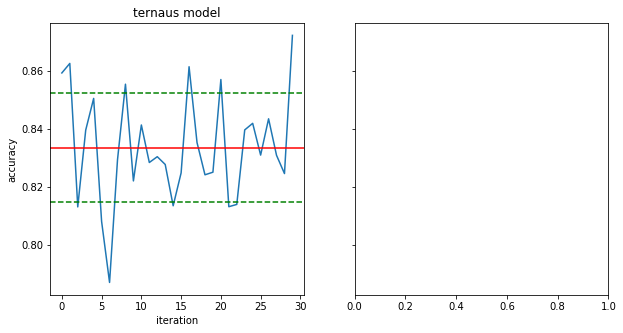

In [131]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

mean, upper, lower = stats(df_ternaus)
ax1.set_title('ternaus model')
ax1.plot(list(df_ternaus.index), list(df_ternaus['acc']))
ax1.axhline(y=mean, color='r')
ax1.axhline(y=upper, linestyle='--', color='g')
ax1.axhline(y=lower, linestyle='--', color='g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy')

# Data augmentation tuning

## data_loader_old

In [4]:
def fast_test(model_fn, iterations, steps_per_iter, epochs=1, lr=1e-4):
    hists = []
    for i in range(iterations):
        model = model_fn(input_size=(256, 256, 1))
        model.compile(optimizer = Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit_generator(train_gen, steps_per_epoch=steps_per_iter, epochs=1)
        hists.append(history.history)
#         r = {k: r[k][-1] for k in r}
#         df = df.append(r, ignore_index=True)
        backend.clear_session()
    return hists

In [5]:
# TODO: Implement test set loader

data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

# why is batch size 2? paper says bs=1
train_gen = trainGenerator(2, train_pth, 'input', 'target', data_gen_args, save_to_dir=None)



In [6]:
hists_baseline_slow = fast_test(unet, 5, 1000, epochs=1, lr=1e-4)

Epoch 1/1
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
1000/1000 [==============================] - 161s 161ms/step - loss: 0.5742 - acc: 0.8896
Epoch 1/1
1000/1000 [==============================] - 159s 159ms/step - loss: 0.5651 - acc: 0.8921
Epoch 1/1
1000/1000 [==============================] - 158s 158ms/step - loss: 0.4570 - acc: 0.8995
Epoch 1/1


KeyboardInterrupt: 

## data_loader

In [25]:
img_sz = (256, 256, 1)
batch_sz = 2

# Models
models = [
    ['unet_baseline', unet, dict(input_size=img_sz)],
]

# Data loaders
train_loader = loader(train_pth, input_generator_train, target_generator_train, batch_sz=batch_sz, img_sz=img_sz[:2])
test_loader = loader(test_pth, input_generator_test, target_generator_test, batch_sz=batch_sz, img_sz=img_sz[:2])

In [26]:
training_params = dict(
    train_steps=1000, 
    val_steps=200, 
    epochs=1, 
    iterations=3, 
    lr=1e-4
)

for model in models:
    print(f'\nTESTING MODEL: {model[0]}')
    results = test_model(model[1], train_loader, test_loader, **training_params, model_params=model[2])


TESTING MODEL: unet_baseline
Epoch 1/1
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
 999/1000 [============================>.] - ETA: 0s - loss: 0.4675 - acc: 0.8973Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
1000/1000 [==============================] - 166s 166ms/step - loss: 0.4675 - acc: 0.8973 - val_loss: 0.3348 - val_acc: 0.9324
Epoch 1/1
1000/1000 [==============================] - 167s 167ms/step - loss: 0.4851 - acc: 0.8936 - val_loss: 0.3304 - val_acc: 0.9326
Epoch 1/1
1000/1000 [==============================] - 167s 167ms/step - loss: 1.2724 - acc: 0.8682 - val_loss: 1.1669 - val_acc: 0.9347


### Test A

input_generator_train = ImageDataGenerator(
     rotation_range=180,
     width_shift_range=0.2,
     height_shift_range=0.2,
     brightness_range=[0.5, 1.5],
     rescale=1./255,           #  rescale pixel vals 0-255 --> 0.0-1.0
     shear_range=0.2,
     zoom_range=[0.5, 1.0],
     horizontal_flip=True,
     fill_mode='reflect',
     data_format='channels_last',
     validation_split=0.0
 )

loss: 0.5713 - acc: 0.8766 - val_loss: 0.3788 - val_acc: 0.9237
loss: 0.6409 - acc: 0.8713 - val_loss: 0.4842 - val_acc: 0.9206
loss: 1.2721 - acc: 0.8673 - val_loss: 1.1907 - val_acc: 0.9294


### Test B

input_generator_train = ImageDataGenerator(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    #brightness_range=[0.5, 1.5],
    rescale=1./255,           #  rescale pixel vals 0-255 --> 0.0-1.0
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest', #nearest
    data_format='channels_last',
    validation_split=0.0
)

loss: 0.4986 - acc: 0.8909 - val_loss: 0.3177 - val_acc: 0.9342
loss: 1.3596 - acc: 0.7805 - val_loss: 1.3306 - val_acc: 0.7968
loss: 0.4908 - acc: 0.8891 - val_loss: 0.3676 - val_acc: 0.9292


### Test C

as B:
fill_mode='reflect'

loss: 0.5527 - acc: 0.8786 - val_loss: 0.3485 - val_acc: 0.9337
loss: 0.5636 - acc: 0.8933 - val_loss: 0.4527 - val_acc: 0.9340
loss: 0.4779 - acc: 0.8942 - val_loss: 0.3359 - val_acc: 0.9326


### Test D

as C:
rotation_range=0.0,

loss: 0.5775 - acc: 0.8873 - val_loss: 0.4613 - val_acc: 0.9319
loss: 1.2456 - acc: 0.8952 - val_loss: 1.1706 - val_acc: 0.9309
loss: 0.4818 - acc: 0.8946 - val_loss: 0.3495 - val_acc: 0.9314

### Test E

as C
brightness_range=[0.8, 1.2]

loss: 0.4811 - acc: 0.8946 - val_loss: 0.3346 - val_acc: 0.9327
loss: 0.4701 - acc: 0.8968 - val_loss: 0.4053 - val_acc: 0.9273
loss: 0.4712 - acc: 0.8971 - val_loss: 0.3999 - val_acc: 0.9275

### Test F

as C
rotation_range=2,
brightness_range=[0.8, 1.2]

loss: 0.4675 - acc: 0.8973 - val_loss: 0.3348 - val_acc: 0.9324
loss: 0.4851 - acc: 0.8936 - val_loss: 0.3304 - val_acc: 0.9326
loss: 1.2724 - acc: 0.8682 - val_loss: 1.1669 - val_acc: 0.9347

# Slow test

In [85]:
hists_zhixuhao_slow = fast_test(unet_zhixuhao, 10, 1000, epochs=1, lr=1e-4)
hists_baseline_slow = fast_test(unet, 10, 1000, epochs=1, lr=1e-4)

Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 1.3618 - acc: 0.7804
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5108 - acc: 0.8934
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5411 - acc: 0.8715
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.7130 - acc: 0.8497
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.4790 - acc: 0.8942
Epoch 1/1
1000/1000 [==============================] - 190s 190ms/step - loss: 0.5763 - acc: 0.8883
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5646 - acc: 0.8913
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5737 - acc: 0.8881
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5536 - acc: 0.8961
Epoch 1/1
1000/1000 [==============================] - 189s 189ms/step - loss: 0.5516 - acc: 0.8968


In [ ]:
df_zhixuhao_slow = hists2df(hists_zhixuhao_slow)
df_baseline_slow = hists2df(hists_baseline_slow)

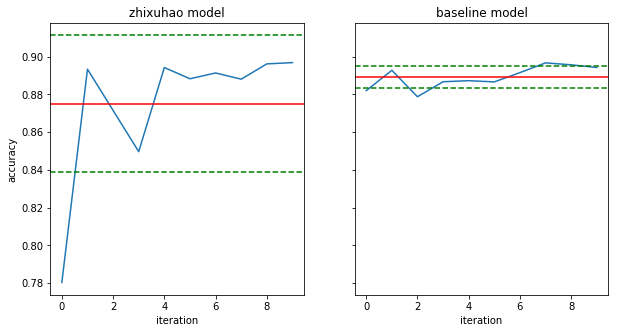

In [88]:
def stats(df):
    mean = df['acc'].mean()
    upper = mean + df['acc'].std()
    lower = mean - df['acc'].std()
    return mean, upper, lower

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

mean, upper, lower = stats(df_zhixuhao_slow)
ax1.set_title('zhixuhao model')
ax1.plot(list(df_zhixuhao_slow.index), list(df_zhixuhao_slow['acc']))
ax1.axhline(y=mean, color='r')
ax1.axhline(y=upper, linestyle='--', color='g')
ax1.axhline(y=lower, linestyle='--', color='g')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy')

mean, upper, lower = stats(df_baseline_slow)
ax2.set_title('baseline model')
ax2.plot(list(df_baseline_slow.index), list(df_baseline_slow['acc']))
ax2.axhline(y=mean, color='r')
ax2.axhline(y=upper, linestyle='--', color='g')
ax2.axhline(y=lower, linestyle='--', color='g')
ax2.set_xlabel('iteration');

In [124]:
hists_ternaus_slow = fast_test(ternausNet16, 10, 1000, epochs=1, lr=1e-4)

NameError: name 'ternausNet16' is not defined

# Ternaus Net

In [99]:
model = ternausNet16(input_size=(256, 256, 1))

In [101]:
model.compile(optimizer = Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
history = model.fit_generator(train_gen, steps_per_epoch=2000, epochs=5)

Epoch 1/5
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
2000/2000 [==============================] - 409s 205ms/step - loss: 0.3079 - acc: 0.9330
Epoch 2/5
2000/2000 [==============================] - 404s 202ms/step - loss: 0.1859 - acc: 0.9594
Epoch 3/5
2000/2000 [==============================] - 404s 202ms/step - loss: 0.1514 - acc: 0.9670
Epoch 4/5
2000/2000 [==============================] - 403s 202ms/step - loss: 0.1338 - acc: 0.9708
Epoch 5/5
2000/2000 [==============================] - 403s 201ms/step - loss: 0.1219 - acc: 0.9734


In [ ]:
def mean_std(df, column:str):
    """Get mean and upper/lower bounds of variance"""
    mean = df[column].mean()
    upper = mean + df[column].std()
    lower = mean - df[column].std()
    return mean, upper, lower

rows = 1
cols = 8
f, axes = plt.subplots(rows, cols, sharey=True, figsize=(15, 5))

for i in range(cols):
    title = f'{models[i][0]}'
    df = pd.read_csv(f'{results_pth}{title}_30steps.csv')
    mean, upper, lower = mean_std(df, 'val_acc')
    axes[i].set_title(title[5:])
    axes[i].plot(list(df.index), list(df['val_acc']))
    axes[i].axhline(y=mean, color='r')
    axes[i].axhline(y=upper, linestyle='--', color='g')
    axes[i].axhline(y=lower, linestyle='--', color='g')
    axes[i].set_xlabel('iteration')
    if i ==0:
        axes[i].set_ylabel('accuracy')


In [122]:
ternaus_2000_5_df = pd.DataFrame(history.history)
ternaus_file = f'{results_pth}ternaus_2000_5.csv'
ternaus_2000_5_df.to_csv(ternaus_file)

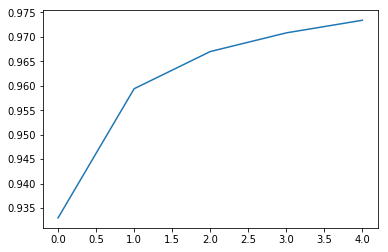

In [123]:
df = pd.read_csv(ternaus_file)
x = df.index
plt.plot(x, df['acc']);